<a href="https://colab.research.google.com/github/HarmanDotpy/ML-Assignment2/blob/main/Q3_4Zero_Shot_Learning_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch.utils.data import DataLoader
from torch.utils.data import ConcatDataset
from torch.utils.data import random_split
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import pandas as pd
import seaborn as sb
import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
def performance_metrics_multiclass(y_pred_test, y_test, num_class, disp_conf = True):
    '''gives the TPR, FPR, acc, precision, recall and F1 score for all classes by comparing the 2 input arrays'''
    #First we calculate the confusion matrix of size num_class*num_class
    #NOTE: Y axis of matrix will be predicted class and x axis wll be true class
    conf_mat = np.zeros((num_class, num_class))
    
    for i in range(num_class):
        for j in range(num_class):
            conf_mat[i, j] = np.logical_and(y_pred_test == i, y_test ==j).sum()
    # Calculating precision, recall, F1 Score for each class
    colnames = ['class', 'Precision', 'Recall', 'F1']
    df = pd.DataFrame(columns = colnames)
    for i in range(num_class):
        TP = conf_mat[i, i]
        FP = conf_mat[i].sum() - conf_mat[i, i]
        TN = conf_mat.sum() - conf_mat[i].sum() - conf_mat[:, i].sum() +  conf_mat[i, i]
        FN = conf_mat[:, i].sum() - conf_mat[i, i]
        P = round((TP)/(TP+FP), 5)
        R = round((TP)/(TP+FN), 5)
        F1 = round(2*P*R/(P+R), 5)
        df = df.append({'class':categories[i], 'Precision':P, 'Recall':R, 'F1':F1 }, ignore_index = True)
    macroF1 = round(df['F1'].mean(), 5)
    accuracy = round((y_pred_test==y_test).mean(), 5)
    
    # NOTE : returning the transpose of the confusion matricx to get true labels on the y axis
    conf_mat = conf_mat.T
    # NORMALIZING the confusion matrix
    conf_mat = np.around(conf_mat/(conf_mat.sum(axis = 1)), decimals = 5)
    
    
    #PLot the matrix if disp_conf = True
    if(disp_conf == True):
        ax = sb.heatmap(conf_mat, vmin = 0, vmax = 1, cmap = sb.light_palette("seagreen", as_cmap=True), xticklabels = categories, yticklabels = categories, annot = True, annot_kws={"size": 12}, fmt=".3f")
    #     ax.figure.axes[-1].yaxis.label.set_size(12)
        plt.xlabel('Predicted Labels', fontsize = 14)
        plt.ylabel('True Labels', fontsize = 14)
        plt.tick_params(axis='both', labelsize=10)
        return conf_mat, df, macroF1, accuracy, plt
    
    return conf_mat, df, macroF1, accuracy

In [12]:
# model hyperparameters
batch_size = 128
num_epochs = 10
num_classes = 10
learning_rate = 0.001

# transforms for the datasets
# MNIST is single channeled, for , eg CIFAR dataset , the normalization has to use mean and variance of all three ie Red, Blue and Green
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,),(0.3081,))])

# download the datasets in folders
train_data = torchvision.datasets.MNIST(root ='./DATA_STORE', train = True, transform = trans, download = True)
test_data = torchvision.datasets.MNIST(root = './DATA_STORE', train = False,transform = trans, download = True)

idx_first5 = (train_data.targets==0) | (train_data.targets==1) | (train_data.targets==2) | (train_data.targets==3)| (train_data.targets==4)

# idx_first5 = (train_data.targets==4)
# idx_last5 = (train_data.targets>4)

train_data.targets = train_data.targets[idx_first5]
train_data.data = train_data.data[idx_first5]
#######################
# idx_first5 = (test_data.targets<=4)
idx_last5 = (test_data.targets==5) | (test_data.targets==6) | (test_data.targets==7) | (test_data.targets==8)| (test_data.targets==9)

test_data.targets = test_data.targets[idx_last5]
test_data.data = test_data.data[idx_last5]

# load into dataloader
train_loader = DataLoader(dataset = train_data, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(dataset = test_data, batch_size = len(test_data), shuffle = False)

In [13]:
# our class inherits from the torch.nn.Module class 

# nn.Conv2d(input channels, output channels, Kernel size, stride, padding)
class ConvNet(nn.Module):
  def __init__(self):
    super(ConvNet, self).__init__()
    self.layer1 = nn.Sequential(
        nn.Conv2d(1, 32, kernel_size = 5, stride = 1, padding = 2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2,stride = 2)
        )
    self.layer2 = nn.Sequential(
        nn.Conv2d(32, 64,kernel_size = 5, stride = 1, padding = 2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2, stride = 2)
        )
    self.drop_out = nn.Dropout()
    self.fc1 = nn.Linear(7*7*64,1000)
    self.fc2 = nn.Linear(1000, 10)

  def forward(self, x):
    out = self.layer1(x)
    out = self.layer2(out)
    out = out.reshape(out.size(0), -1)    
    out = self.drop_out(out)
    out = self.fc1(out)
    out = self.fc2(out)
    return out

In [14]:
#  initializing the model
model = ConvNet()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [15]:
# Training the model
totalsteps = len(train_loader)
losslist = []
accuracylist = []
for epoch in range(num_epochs):
  for i, (images, labels) in enumerate(train_loader):
    images, labels = images.to(device), labels.to(device)
    # FORWARD PROP, model(images) automatically calls forward
    outputs = model(images)
    loss = criterion(outputs, labels)
    losslist.append(loss.item())

    # BACK PROP
    # make the gradients zero
    optimizer.zero_grad() 
    # perform the backward propagation and get the gradients
    loss.backward()
    # adam optimizer training step . We use the gradients in this step
    optimizer.step()

    # Accuracy
    # Note we take batch_size amounts of y's at a time
    total = labels.size(0)
    predicted = torch.max(outputs.data,1)[1]
    correct = (predicted == labels).sum().item()
    accuracy = correct / total
    accuracylist.append(accuracy)

    # item() is used for getting the scalar from a tensor
    if(i + 1) % 100 == 0:
      print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'.format(epoch + 1, num_epochs, i+1, totalsteps, loss.item(),(accuracy)*100 ))


Epoch [1/10], Step [100/240], Loss: 0.0953, Accuracy: 96.88%
Epoch [1/10], Step [200/240], Loss: 0.0180, Accuracy: 99.22%
Epoch [2/10], Step [100/240], Loss: 0.0201, Accuracy: 99.22%
Epoch [2/10], Step [200/240], Loss: 0.0486, Accuracy: 97.66%
Epoch [3/10], Step [100/240], Loss: 0.0070, Accuracy: 99.22%
Epoch [3/10], Step [200/240], Loss: 0.0348, Accuracy: 98.44%
Epoch [4/10], Step [100/240], Loss: 0.0202, Accuracy: 99.22%
Epoch [4/10], Step [200/240], Loss: 0.0202, Accuracy: 99.22%
Epoch [5/10], Step [100/240], Loss: 0.0275, Accuracy: 99.22%
Epoch [5/10], Step [200/240], Loss: 0.0009, Accuracy: 100.00%
Epoch [6/10], Step [100/240], Loss: 0.0011, Accuracy: 100.00%
Epoch [6/10], Step [200/240], Loss: 0.0117, Accuracy: 99.22%
Epoch [7/10], Step [100/240], Loss: 0.0045, Accuracy: 100.00%
Epoch [7/10], Step [200/240], Loss: 0.0005, Accuracy: 100.00%
Epoch [8/10], Step [100/240], Loss: 0.0098, Accuracy: 100.00%


KeyboardInterrupt: ignored

In [39]:
# model.eval()
# categories = ['{}'.format(i+5) for i in range(5)]
# with torch.no_grad():
#   correct = 0
#   total = 0
#   # The following loop runs only for 1 time as the batch size for test loader is the size of number of test images only
#   for images, labels in test_loader:
#     images, labels = images.to(device), labels.to(device)
#     outputs = model(images)
#     predictions = torch.max(output.data[:,5:],1)[1]+torch.Tensor([5]).to(device)


#     confmat, df, macrof1, acc, plt = performance_metrics_multiclass(predicted.to('cpu').numpy(), labels.to('cpu').numpy(), num_classes)
#     print(confmat)
#     print(df)
#     print('macroF1 = {}, accuracy = {}'.format(macrof1, acc))
#     total += labels.size(0)
#     correct += (predicted == labels).sum().item()

#   print('Test Accuracy for {} test images = {} %'.format(len(test_loader.dataset) ,(correct/total)*100))

#   # torch.save(model.state_dict(), './MODEL_STORE/MNIST_conve_nets.ckpt')


#   ##Performance metrics


GRAPH PLOTS


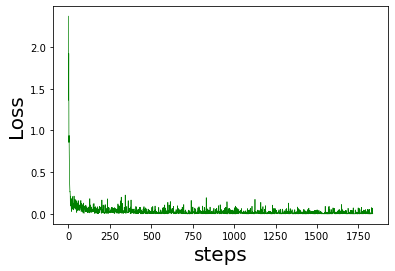

In [27]:
import matplotlib.pyplot as plt
plt.plot(losslist, color = 'green', linewidth = 0.7 )
plt.xlabel('steps', fontsize=20)
plt.ylabel('Loss', fontsize=20)
# plt.plot(accuracylist, color = 'red', linewidth = 0.7)
# plt.xlim(0,700)
# plt.ylim(0,1.05)
plt.show()


In [40]:
##TESTING

In [38]:
import numpy as np
fig = plt.figure()
rows = 2
columns = 5
count1 = 0
count2 = 1
predicted = np.zeros(10)
total = 0
correct = 0
print('taking every {}th image from the test dataset :'.format(every))
for i, (images, labels) in enumerate(test_loader):
  images, labels = images.to(device), labels.to(device)
  imgs = images.to('cpu')
  output = model(images)
  predictions = torch.max(output.data[:,5:],1)[1]+5
  print(predictions)
  # print(output)
  for j in range(images.size(0)):
    total+=1
    if(predictions[j] == labels[j] and count1<1000):
        correct+=1

print('Accuracy on Novel classes = {}%'.format(correct/total*100))

taking every 1th image from the test dataset :
tensor([9, 9, 9,  ..., 8, 6, 9], device='cuda:0')
Accuracy on Novel classes = 23.14338613454022%


<Figure size 432x288 with 0 Axes>

## USING PCA facts and common knowledge about digits we classify output1 as 7, 3 as 8 ... beause they look similar and are close in tPCA plot and result we get is a 11 percent increae in accuracy

In [47]:
import numpy as np
fig = plt.figure()
rows = 2
columns = 5
count1 = 0
count2 = 1
predicted = np.zeros(10)
total = 0
correct = 0
print('taking every {}th image from the test dataset :'.format(every))
for i, (images, labels) in enumerate(test_loader):
  images, labels = images.to(device), labels.to(device)
  imgs = images.to('cpu')
  output = model(images)
  predictions = torch.max(output.data[:,0:5],1)[1]
  print(predictions)
  prediction_changed = np.zeros(predictions.shape[0])
  for x in range(predictions.shape[0]):
    if(predictions[x]==4):
      prediction_changed[x]=9
    if(predictions[x]==0):
      predictions[x]=6
    if(predictions[x]==3):
      prediction_changed[x]=8
    if(predictions[x]==1):
      prediction_changed[x]=7
    if(predictions[x]==2):
      prediction_changed[x]=5
  print(prediction_changed)
  # print(output)
  for j in range(images.size(0)):
    total+=1
    if(prediction_changed[j] == labels[j] and count1<1000):
        correct+=1

print('Accuracy on Novel classes = {}%'.format(correct/total*100))

taking every 1th image from the test dataset :
tensor([3, 4, 0,  ..., 4, 0, 0], device='cuda:0')
[8. 9. 0. ... 9. 0. 0.]
Accuracy on Novel classes = 34.41678666940959%


<Figure size 432x288 with 0 Axes>

# SOME RANDOM EXPERIMENTS 
Using test data images

taking every 50th image from the test dataset :


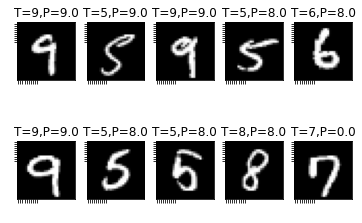

The output predictions by the model are : 
[9. 9. 9. 8. 8. 9. 8. 8. 8. 0.]


In [50]:
import numpy as np
fig = plt.figure()
rows = 2
columns = 5
count1 = 0
count2 = 1
predicted = np.zeros(10)
every = 50
print('taking every {}th image from the test dataset :'.format(every))
for i, (images, labels) in enumerate(test_loader):
  images, labels = images.to(device), labels.to(device)
  imgs = images.to('cpu')

  for j in range(images.size(0)):
    if((j+1) % 50 ==0 and count1<10):
      if(count2 % 50 == 0):
        output = model(images)
        predictions = torch.max(output.data[:,0:5],1)[1]
        # print(predictions)
        prediction_changed = np.zeros(predictions.shape[0])
        for x in range(predictions.shape[0]):
          if(predictions[x]==4):
            prediction_changed[x]=9
          if(predictions[x]==0):
            predictions[x]=6
          if(predictions[x]==3):
            prediction_changed[x]=8
          if(predictions[x]==1):
            prediction_changed[x]=7
          if(predictions[x]==2):
            prediction_changed[x]=5
        predicted[count1] = prediction_changed[j].item()


        a = fig.add_subplot(rows, columns, count1+1)
        a.title.set_text('T={},P={}'.format(labels[j].item(), prediction_changed[j].item()))
        # a.set_xticks()
        # a.set_title(labels[j].item(), color ='white')
        plt.imshow(np.array(imgs[j]).reshape((28,28)), cmap = 'gray')
        x = np.arange(10)
        y = np.arange(10)
        plt.xticks(x, " ")
        plt.yticks(y, " ")
        count1+=1

    count2+=1
plt.show()
print('The output predictions by the model are : ')
print(predicted)


taking every 50th image from the test dataset :
torch.Size([4861, 5])
tensor([9, 7, 9,  ..., 8, 6, 9], device='cuda:0')


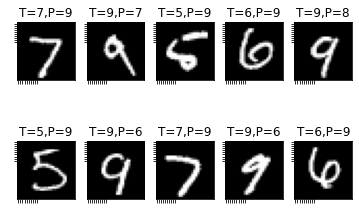

The output predictions by the model are : 
[9. 7. 9. 9. 8. 9. 6. 9. 6. 9.]


In [24]:
import numpy as np
fig = plt.figure()
rows = 2
columns = 5
count1 = 0
count2 = 1
predicted = np.zeros(10)
every = 50
print('taking every {}th image from the test dataset :'.format(every))
for i, (images, labels) in enumerate(test_loader):
  images, labels = images.to(device), labels.to(device)
  imgs = images.to('cpu')
  output = model(images)
  predictions = torch.max(output.data[:,5:],1)[1]+5
  print(predictions)
  # print(output)
  for j in range(images.size(0)):
    if(predictions[j] != labels[j] and count1<10):
      predicted[count1] = predictions[j].item()
      a = fig.add_subplot(rows, columns, count1+1)
      a.title.set_text('T={},P={}'.format(labels[j].item(), predictions[j].item()))
      # a.set_xticks()
      # a.set_title(labels[j].item(), color ='white')
      plt.imshow(np.array(imgs[j]).reshape((28,28)), cmap = 'gray')
      x = np.arange(10)
      y = np.arange(10)
      plt.xticks(x, " ")
      plt.yticks(y, " ")
      count1+=1


# plt.savefig('./Q3.1_wrong_classified.jpeg', dpi = 300, bbox_inches = 'tight')
plt.show()
print('The output predictions by the model are : ')
print(predicted[:count1])